# Landsat Testing Dataset
## [Using Novelty Detection in Keras with Generative Adversarial Network]

This notebook is for test phase Novelty Detection. To Train the model, run this first.
```bash
python models.py
```

It is recommended to understand how the model works in general before continuing the implementation. 

→ [How to do Novelty Detection in Keras with Generative Adversarial Network (Part 1)](https://www.dlology.com/blog/how-to-do-novelty-detection-in-keras-with-generative-adversarial-network/)


In [1]:
from utils import *
from kh_tools import *
import models
import imp
imp.reload(models)
from models import ALOCC_Model
from keras.datasets import mnist

from keras.losses import binary_crossentropy
from keras import backend as K

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
self =ALOCC_Model(dataset_name='mnist', input_height=28,input_width=28)

W0115 09:52:47.495476 140077802424128 deprecation_wrapper.py:119] From /home/rcolomina/ALOCC_Keras/env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0115 09:52:47.496596 140077802424128 deprecation_wrapper.py:119] From /home/rcolomina/ALOCC_Keras/env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0115 09:52:47.503527 140077802424128 deprecation_wrapper.py:119] From /home/rcolomina/ALOCC_Keras/env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0115 09:52:47.517673 140077802424128 deprecation_wrapper.py:119] From /home/rcolomina/ALOCC_Keras/env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Pl


discriminator
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_input (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
d_h0_conv (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
d_h1_conv (Conv2D)           (None, 7, 7, 32)          12832     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 32)          0         
_________________________________________________________________
d_h2_conv (Conv2D)           (None, 4, 4, 64)          51264 

/home/rcolomina/ALOCC_Keras/env/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## Choose a stopping criterion
The training procedure is stopped when R successfully maps noisy images to clean images carrying the concept of the target class.  When R can reconstruct its input with minimum error. In the following case, we pick the epoch 3.

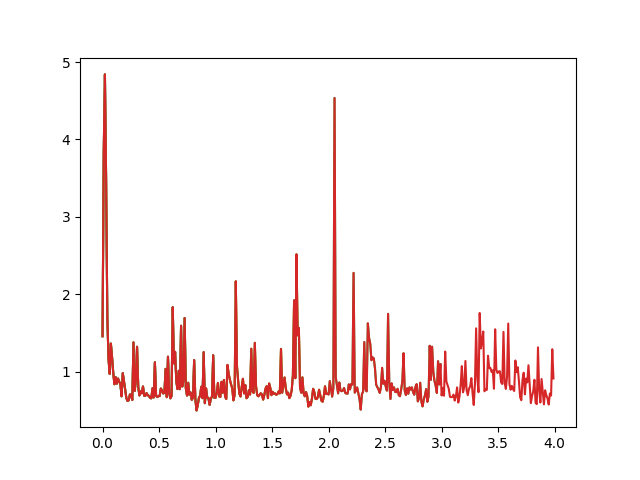

In [7]:
# This image was generated at the end of the models.py training procedure to help pick a ending epoch to load. 
from IPython.display import Image
Image(filename='plot_g_recon_losses_3.png') 


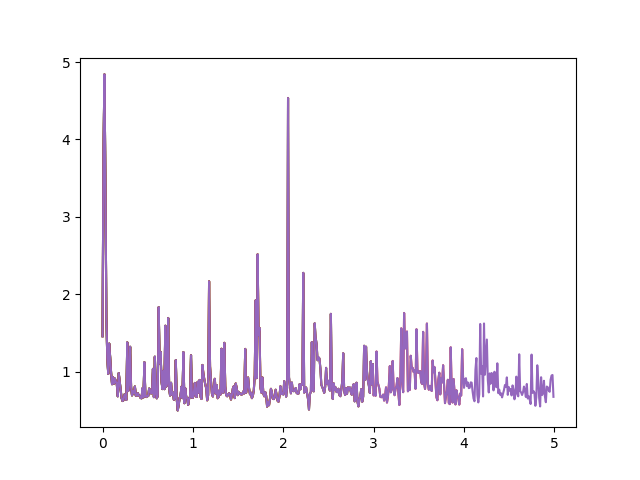

In [82]:
from IPython.display import Image
Image(filename='plot_g_recon_losses_4.png')

In [6]:
# Load the epoch #3 saved weights.
self.adversarial_model.load_weights('./checkpoint/ALOCC_Model_4.h5')

NameError: name 'self' is not defined

In [3]:

#(X_train, y_train), (_, _) = mnist.load_data()
#X_train = X_train / 255

from landsat_data_loader import LandsatDataLoader
root = "/QCOLT/QCOLT_DEV_OPS/"
path = root +'/TDS_NOVELTY_DETECTION/EXP_02//nominal_chips/'    
loader = LandsatDataLoader(path)   
X_train = loader.load_data()
X_train = X_train / 255
#print(X_train.shape)
print("Number of samples loaded =",X_train.shape[0])
print("Dimensions (H,W) = ({},{})".format(X_train.shape[1],X_train.shape[2]))

Number of samples loaded = 9507
Dimensions (H,W) = (28,28)


## Test the reconstruction loss and Discriminator output
The `abnormal` image has a **`larger` reconstruction loss** and **`smaller` discriminator output value**.

In [4]:

def test_reconstruction(index=0):
       
    
    data = X_train[index].reshape(-1, 28, 28, 1)[0:1]
    
    print(data.shape)
    model_predicts = self.adversarial_model.predict(data)
    
    
    exit()
    
    
    print(model_predicts[0])
    exit()
    fig= plt.figure(figsize=(8, 8))
    columns = 1
    rows = 2
    fig.add_subplot(rows, columns, 1)
    input_image = data[0].reshape((28, 28))
    reconstructed_image = model_predicts[0].reshape((28, 28))
    plt.title('Input')
    plt.imshow(input_image, label='Input')
    fig.add_subplot(rows, columns, 2)
    plt.title('Reconstruction')
    plt.imshow(reconstructed_image, label='Reconstructed')
    plt.show()
    # Compute the mean binary_crossentropy loss of reconstructed image.
    #y_true = K.variable(reconstructed_image)
    #y_pred = K.variable(input_image)
    #error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    #print('Reconstruction loss:', error)
    #print('Discriminator Output:', model_predicts[1][0][0])

### Normal case
The network was trained with label == 1.

In [5]:
test_reconstruction(0)

(1, 28, 28, 1)


NameError: name 'self' is not defined

## Abnormal cases
The network was not trained on those labels, so the Generator/R network find it hard to reconstruct the input images reflected in higher reconstruction loss values.

Discriminator also outputs a lower value compared to normal ones.

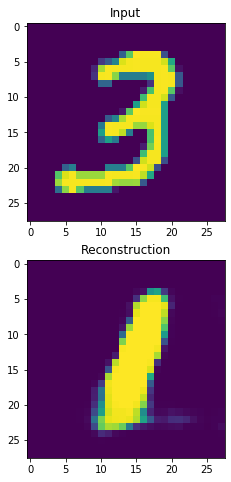

Reconstruction loss: 0.97681373
Discriminator Output: 0.37664634


In [59]:
test_reconstruction(3)

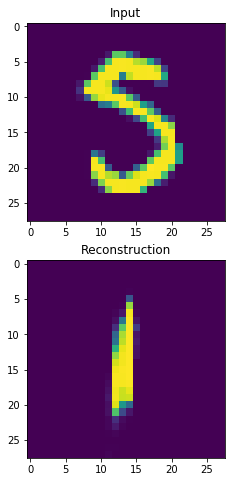

Reconstruction loss: 0.94355774
Discriminator Output: 0.4031163


In [49]:
test_reconstruction(5)

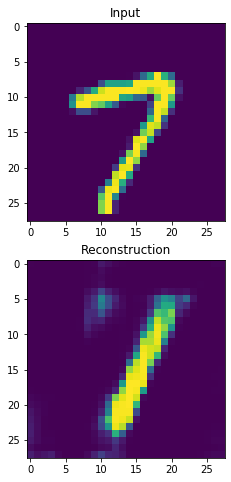

Reconstruction loss: 0.6265337
Discriminator Output: 0.3243893


In [17]:
test_reconstruction(7)